# IXI Dataset Classification Task (T1 MRI Images)

In [ ]:
import os 
import numpy as np
#Backend can be changed by uncommenting desired setting
os.environ['KERAS_BACKEND'] = 'jax'
#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['KERAS_BACKEND'] = 'torch'
import keras
import tensorflow as tf
from tensorflow import data as tf_data
import keras.layers as K
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import ants
import glob
import pandas as pd
import time
import random
%matplotlib inline
sns.set_palette("bright")
sns.set_style("whitegrid")
keras.utils.set_random_seed(0)


## Data 

**Dataset source:** http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar
(dataset download may take some time.)

tar file can extracted as : `tar -xvf IXI-T1.tar`

The image files have `.nii.gz` extension. The images are further extracted to .nii using gzip (`gzip -d *.nii.gz`), but is not necessary as AntsPy can read compressed image files too.

In [2]:

#load file containing image information.
df_data = pd.read_csv("./datasets/IXI_dataset/IXI.csv")
sub_id = df_data['IXI_ID'].tolist()
sub_type = df_data['SEX_ID (1=m, 2=f)'].tolist()

dict_id_to_type = {idx: sex for idx, sex in zip(sub_id, sub_type)}

#provide the location of the image files
files = (glob.glob("./datasets/IXI_dataset/*.nii"))
random.shuffle(files)

list_train_data = []
list_test_data = []
list_train_labels = []
list_test_labels = []
list_plot = []


first_image = []

for idx, ff in enumerate(files):
    print(f"Counter: {idx}", end="\r")
    fname = os.path.basename(ff)
    im = ants.image_read(ff)
    #Resampling image to lower dimensions for faster training
    im = ants.resample_image(im, (128,128,64),use_voxels=True, interp_type=0)

    #Rigid registration of all images to a single image (arbitrarily chosen, first one in this case)
    #may improve performance a bit
    if idx==0:
        first_image.append(im)
    else:
        im = ants.registration(first_image[0], im, type_of_transform='Rigid')['warpedmovout']

    #Normalize image data
    im = ants.iMath(im, 'Normalize')

    #Storing a list of images for plotting
    if idx<5:
        list_plot.append(im)
    im = im.numpy()


    sub_id = int(fname.split("-")[0][3:]) # getting subject id from name like IXI012-HH-1211-T1.nii

    # training dataset
    if sub_id in dict_id_to_type and idx<400: #add if subject info exists in csv file
        list_train_data.append(im)
        list_train_labels.append(dict_id_to_type[sub_id]-1)

    # test dataset
    if sub_id in dict_id_to_type and idx>=400:
        list_test_data.append(im)
        list_test_labels.append(dict_id_to_type[sub_id]-1)

print(f"")
print(f"Total training images: {len(list_train_data)}")
print(f"Total test images: {len(list_test_data)}")





Counter: 580
Total training images: 389
Total test images: 177


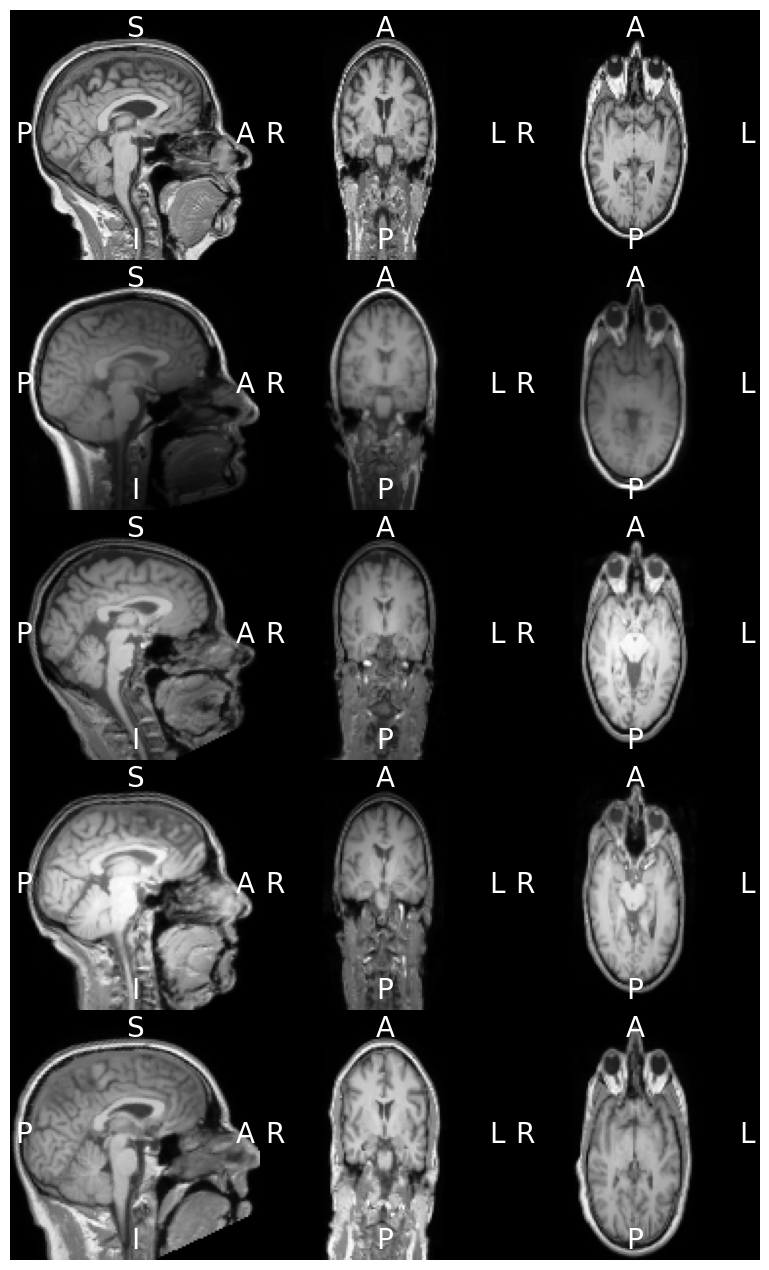

In [3]:
#plotting images
ants.plot_ortho_stack(list_plot)

In [ ]:

list_train_labels = np.array(list_train_labels)
list_train_labels = np.eye(2)[list_train_labels]

list_test_labels = np.array(list_test_labels)
list_test_labels = np.eye(2)[list_test_labels]

def add_channel_dim(image, label):
    return tf.expand_dims(image, -1), label
    

#with tf.device("/cpu:0"):
train_dataset = tf.data.Dataset.from_tensor_slices((list_train_data, list_train_labels))

train_dataset = train_dataset.map(add_channel_dim)
train_dataset = train_dataset.shuffle(buffer_size=len(list_train_data)).batch(1)

#with tf.device("/cpu:0"):
test_dataset = tf.data.Dataset.from_tensor_slices((list_test_data, list_test_labels))

test_dataset = test_dataset.map(add_channel_dim)
test_dataset = test_dataset.batch(1)

del list_train_data
del list_test_data

In [5]:
check = list(train_dataset.take(1))
print(check[0][0].shape)
print(check[0][1].shape)

check = list(test_dataset.take(1))
print(check[0][0].shape)
print(check[0][1].shape)

(1, 128, 128, 64, 1)
(1, 2)
(1, 128, 128, 64, 1)
(1, 2)


In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, add, GlobalAveragePooling3D

def res_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), conv_shortcut=False):
    shortcut = x
    
    x = Conv3D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv3D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    if conv_shortcut:
        shortcut = Conv3D(filters, (1, 1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = add([x, shortcut])
    x = Activation('relu')(x)
    
    return x

def resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    
    # 3x3x3 conv, 64 filters
    x = res_block(x, 64)
    x = res_block(x, 64)
    x = res_block(x, 64)
    
    # 3x3x3 conv, 128 filters
    x = res_block(x, 128, strides=(2, 2, 2), conv_shortcut=True)
    x = res_block(x, 128)
    x = res_block(x, 128)
    x = res_block(x, 128)
    
    # 3x3x3 conv, 256 filters
    x = res_block(x, 256, strides=(2, 2, 2), conv_shortcut=True)
    x = res_block(x, 256)
    x = res_block(x, 256)
    x = res_block(x, 256)
    x = res_block(x, 256)
    x = res_block(x, 256)
    
    # 3x3x3 conv, 512 filters
    x = res_block(x, 512, strides=(2, 2, 2), conv_shortcut=True)
    x = res_block(x, 512)
    x = res_block(x, 512)
    
    x = GlobalAveragePooling3D()(x)
    x = Dense(1024, activation='relu')(x)
    x = K.Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = K.Dropout(0.5)(x)
    x = Dense(num_classes, activation=None)(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    return model

In [7]:

train_dataset = train_dataset.prefetch(buffer_size=1)
validation_dataset = test_dataset.prefetch(buffer_size=1)


model = resnet50(input_shape=(128, 128, 64, 1), num_classes=2)
#print(model.summary())

def scheduler(epoch, lr):
    if epoch>1 and epoch%10==0:
        return lr*0.1
    else:
        return lr
        

epochs = 30

callbacks = [
    
    keras.callbacks.ModelCheckpoint("ixi_best_checkpoint.keras", save_best_only=True),
    keras.callbacks.CSVLogger("ixi_classification_training.log"),
    keras.callbacks.LearningRateScheduler(scheduler)
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=5e-05),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)
model.fit(
    train_dataset,
    batch_size=1,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
)


Epoch 1/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - acc: 0.5888 - loss: 0.9520 - val_acc: 0.5480 - val_loss: 0.7267 - learning_rate: 5.0000e-05
Epoch 2/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - acc: 0.4963 - loss: 0.9105 - val_acc: 0.5876 - val_loss: 0.6466 - learning_rate: 5.0000e-05
Epoch 3/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - acc: 0.6610 - loss: 0.6779 - val_acc: 0.7910 - val_loss: 0.4255 - learning_rate: 5.0000e-05
Epoch 4/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - acc: 0.7990 - loss: 0.4685 - val_acc: 0.7966 - val_loss: 0.4337 - learning_rate: 5.0000e-05
Epoch 5/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - acc: 0.8259 - loss: 0.4221 - val_acc: 0.8983 - val_loss: 0.3836 - learning_rate: 5.0000e-05
Epoch 6/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - acc: 0.8900 - loss: 0.2616 - val_acc: 0.7684 - val_loss: 0.4367 - learning_rate: 5.0000e-05
Epoch 7/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - acc: 0.8912 - loss: 0.2645 - val_acc: 0.8644 - val_loss:

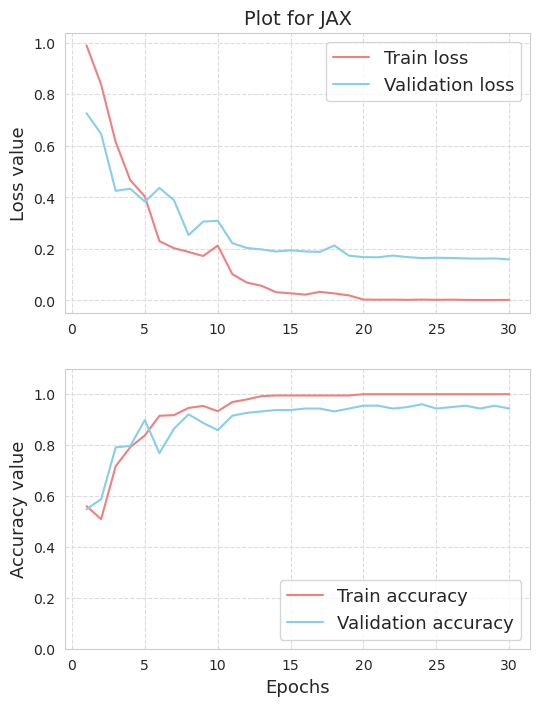

In [8]:
#With all three augmentation
#Plot for jax
history = model.history

train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(2,1, figsize=(6,8))

axs[0].plot(list(range(1, epochs+1)), train_loss, color='lightcoral', label='Train loss')
axs[0].plot(list(range(1, epochs+1)), val_loss, color='skyblue', label='Validation loss')
axs[0].set_title("Plot for JAX", fontsize=14)
axs[0].set_ylabel('Loss value',fontsize=13)
axs[0].legend(loc='upper right',fontsize=13)
axs[0].grid(color="gainsboro",linestyle='--')

axs[1].plot(list(range(1, epochs+1)), train_acc, color='lightcoral', label='Train accuracy')
axs[1].plot(list(range(1, epochs+1)), val_acc, color='skyblue', label='Validation accuracy')
axs[1].set_ylabel('Accuracy value',fontsize=13)
axs[1].set_xlabel('Epochs',fontsize=13)
axs[1].set_ylim([0.0,1.1])
axs[1].legend(loc='lower right',fontsize=13)
axs[1].grid(color="gainsboro",linestyle='--')

plt.show()


## Average time 
Average time JAX: 25ms/step 

Average time Torch: 50ms/step 

Average time Tensorflow: 26ms/step


